<a href="https://colab.research.google.com/github/Abdullah-Al-Roman/research-paper/blob/main/mbert_toxic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [5]:
df = pd.read_csv('/content/merged (1).csv')

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased',
                                                     num_labels=len(df['labels'].unique()))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['labels'] = label_encoder.fit_transform(df['labels'])


In [8]:
max_length = 128

In [9]:
def tokenize_data(texts):
    return tokenizer(texts.tolist(),
                    padding=True,
                    truncation=True,
                    max_length=max_length,
                    return_tensors='pt')


In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(df['text'],
                                                   df['labels'],
                                                   test_size=0.3,
                                                   random_state=42,
                                                   stratify=df['labels'])

X_val, X_test, y_val, y_test = train_test_split(X_temp,
                                               y_temp,
                                               test_size=0.5,
                                               random_state=42,
                                               stratify=y_temp)

In [11]:
train_encodings = tokenize_data(X_train)
val_encodings = tokenize_data(X_val)
test_encodings = tokenize_data(X_test)

# Convert labels to tensors
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)
test_labels = torch.tensor(y_test.values)


In [12]:
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    train_labels
)

val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    val_labels
)

test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    test_labels
)

In [13]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 16
best_val_loss = float('inf')
best_model_state = None


In [15]:
model.train()
for epoch in range(num_epochs):
    # Training
    total_train_loss = 0
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    total_val_loss = 0
    val_preds = []
    val_labels_list = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            total_val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=1)

            val_preds.extend(preds.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_labels_list, val_preds)

    print(f'Epoch {epoch + 1}/{num_epochs}:')
    print(f'Average Training Loss: {avg_train_loss:.4f}')
    print(f'Average Validation Loss: {avg_val_loss:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.4f}\n')

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict().copy()

# Load best model for testing
model.load_state_dict(best_model_state)

Epoch 1/16:
Average Training Loss: 1.3606
Average Validation Loss: 1.1784
Validation Accuracy: 0.5653

Epoch 2/16:
Average Training Loss: 1.0520
Average Validation Loss: 1.1040
Validation Accuracy: 0.5853

Epoch 3/16:
Average Training Loss: 0.8791
Average Validation Loss: 1.0742
Validation Accuracy: 0.6047

Epoch 4/16:
Average Training Loss: 0.7143
Average Validation Loss: 1.0800
Validation Accuracy: 0.6260

Epoch 5/16:
Average Training Loss: 0.5830
Average Validation Loss: 1.1920
Validation Accuracy: 0.6187

Epoch 6/16:
Average Training Loss: 0.4481
Average Validation Loss: 1.2444
Validation Accuracy: 0.6340

Epoch 7/16:
Average Training Loss: 0.3593
Average Validation Loss: 1.3099
Validation Accuracy: 0.6307

Epoch 8/16:
Average Training Loss: 0.2719
Average Validation Loss: 1.4384
Validation Accuracy: 0.6380

Epoch 9/16:
Average Training Loss: 0.2278
Average Validation Loss: 1.5403
Validation Accuracy: 0.6233

Epoch 10/16:
Average Training Loss: 0.1800
Average Validation Loss: 1.682

<All keys matched successfully>

In [16]:
model.eval()
test_preds = []
test_labels_list = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels_list.extend(labels.cpu().numpy())

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Calculate all metrics
test_accuracy = accuracy_score(test_labels_list, test_preds)
test_precision = precision_score(test_labels_list, test_preds, average='weighted')
test_recall = recall_score(test_labels_list, test_preds, average='weighted')
test_f1 = f1_score(test_labels_list, test_preds, average='weighted')
conf_matrix = confusion_matrix(test_labels_list, test_preds)
class_report = classification_report(test_labels_list, test_preds, target_names=label_encoder.classes_)


In [18]:
print("\nTest Results:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

print("\nClassification Report:")
print(class_report)


Test Results:
Accuracy: 0.6027
Precision: 0.6096
Recall: 0.6027
F1 Score: 0.6022

Classification Report:
                       precision    recall  f1-score   support

        Cyberbullying       0.59      0.50      0.54       423
Gender_Discrimination       0.58      0.58      0.58       171
            Political       0.56      0.73      0.64       192
               Racism       0.61      0.58      0.59       168
     Religious_Hatred       0.84      0.70      0.76       171
              Sarcasm       0.56      0.63      0.59       375

             accuracy                           0.60      1500
            macro avg       0.62      0.62      0.62      1500
         weighted avg       0.61      0.60      0.60      1500



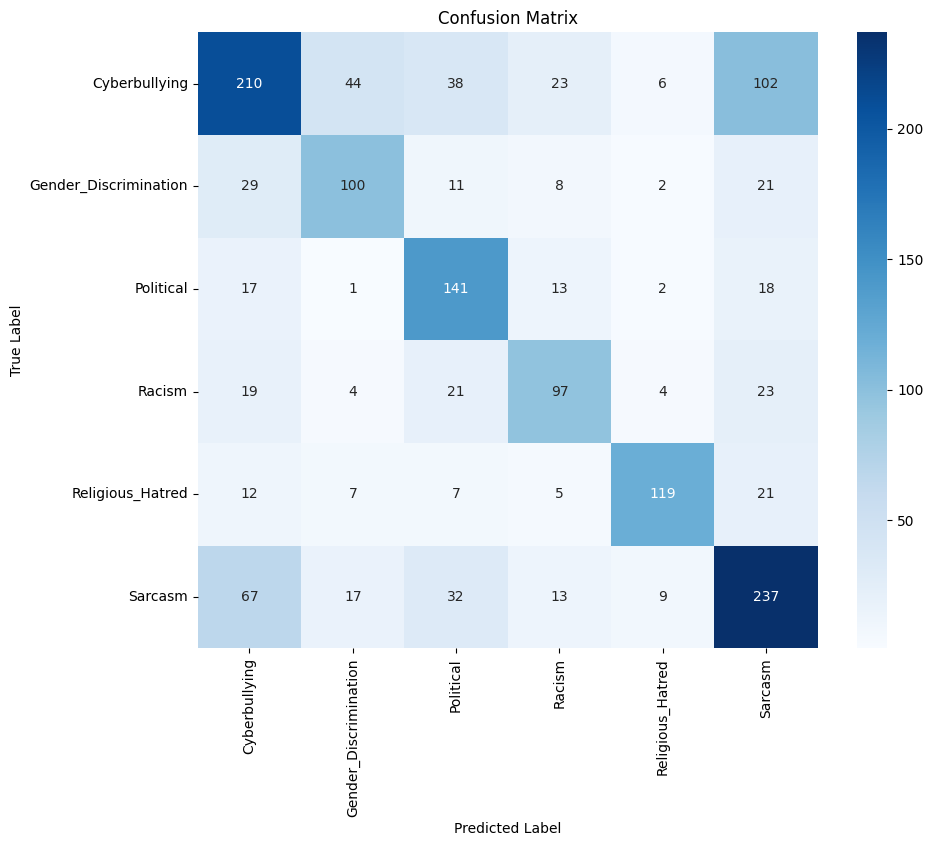

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('mbert.png')
plt.show()

In [20]:
with open('classification_results.txt', 'w') as f:
    f.write("Test Results:\n")
    f.write(f"Accuracy: {test_accuracy:.4f}\n")
    f.write(f"Precision: {test_precision:.4f}\n")
    f.write(f"Recall: {test_recall:.4f}\n")
    f.write(f"F1 Score: {test_f1:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(class_report)